In [21]:
#Data Acquisition
import yfinance as yf

# Fetch historical stock data
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Example usage
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-01-01'
stock_data = get_stock_data(ticker, start_date, end_date)
print(stock_data.head())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  72.960464  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.251129  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.826866  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.484367  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.650352  132079200


In [22]:
#Data Preprocessing
import pandas as pd

# Handle missing values
def preprocess_data(data):
    data = data.dropna()
    return data

stock_data = preprocess_data(stock_data)

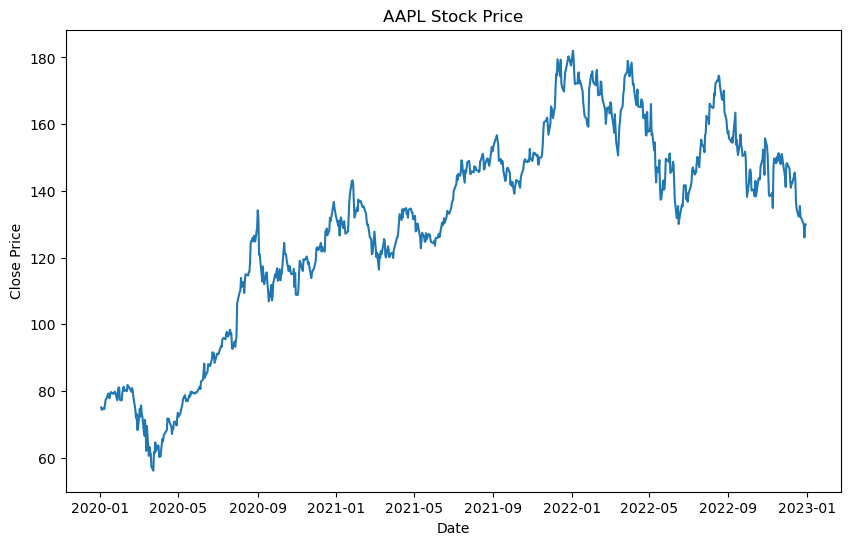

Mean Price: 130.31181210311001
Median Price: 135.37999725341797
Variance Price: 934.3106535870312


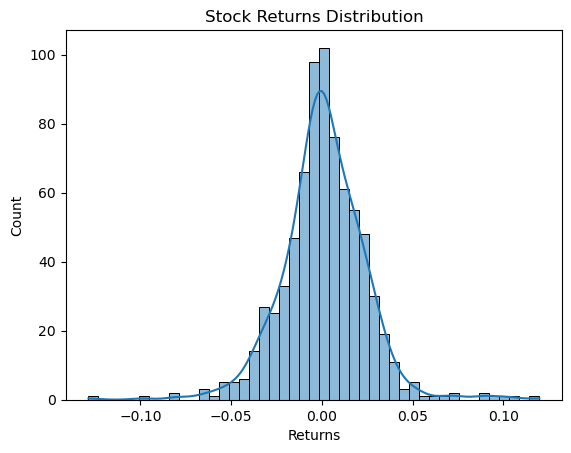

In [23]:
#Exploratory Data Analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize stock price trends
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Close'])
plt.title(f'{ticker} Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# Calculate and plot basic statistics
mean_price = stock_data['Close'].mean()
median_price = stock_data['Close'].median()
variance_price = stock_data['Close'].var()

print(f'Mean Price: {mean_price}')
print(f'Median Price: {median_price}')
print(f'Variance Price: {variance_price}')

# Stock returns
stock_data['Returns'] = stock_data['Close'].pct_change()
sns.histplot(stock_data['Returns'].dropna(), kde=True)
plt.title('Stock Returns Distribution')
plt.show()

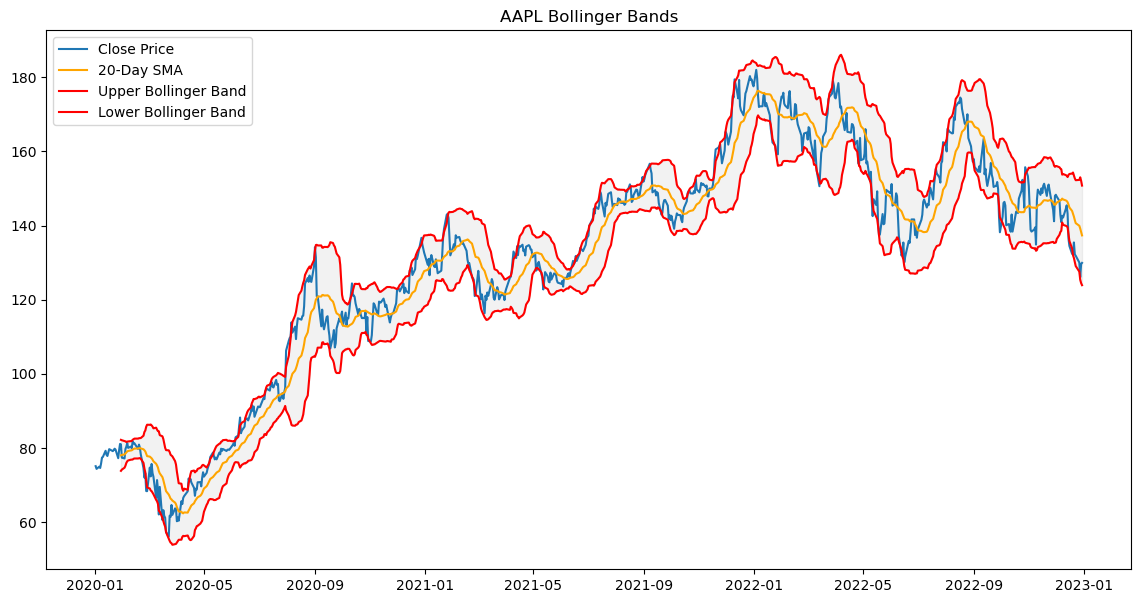

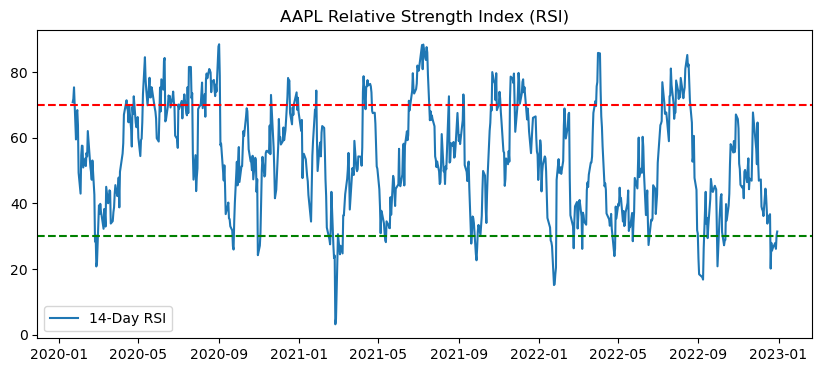

Date
2020-01-02         NaN
2020-01-03         NaN
2020-01-06         NaN
2020-01-07         NaN
2020-01-08         NaN
                ...   
2022-12-23    140.6610
2022-12-27    139.9515
2022-12-28    139.1950
2022-12-29    138.2740
2022-12-30    137.3550
Name: SMA_20, Length: 756, dtype: float64


In [24]:
#Statistical Evaluation
# Moving Averages
stock_data['SMA_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['EMA_20'] = stock_data['Close'].ewm(span=20, adjust=False).mean()

# Bollinger Bands
stock_data['STD_20'] = stock_data['Close'].rolling(window=20).std()
stock_data['Upper_Band'] = stock_data['SMA_20'] + (stock_data['STD_20'] * 2)
stock_data['Lower_Band'] = stock_data['SMA_20'] - (stock_data['STD_20'] * 2)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Close Price')
plt.plot(stock_data['SMA_20'], label='20-Day SMA', color='orange')
plt.plot(stock_data['Upper_Band'], label='Upper Bollinger Band', color='red')
plt.plot(stock_data['Lower_Band'], label='Lower Bollinger Band', color='red')
plt.fill_between(stock_data.index, stock_data['Upper_Band'], stock_data['Lower_Band'], color='grey', alpha=0.1)
plt.title(f'{ticker} Bollinger Bands')
plt.legend()
plt.show()

# Relative Strength Index (RSI)
def compute_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

stock_data['RSI_14'] = compute_rsi(stock_data)

# Plotting RSI
plt.figure(figsize=(10, 4))
plt.plot(stock_data['RSI_14'], label='14-Day RSI')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title(f'{ticker} Relative Strength Index (RSI)')
plt.legend()
plt.show()

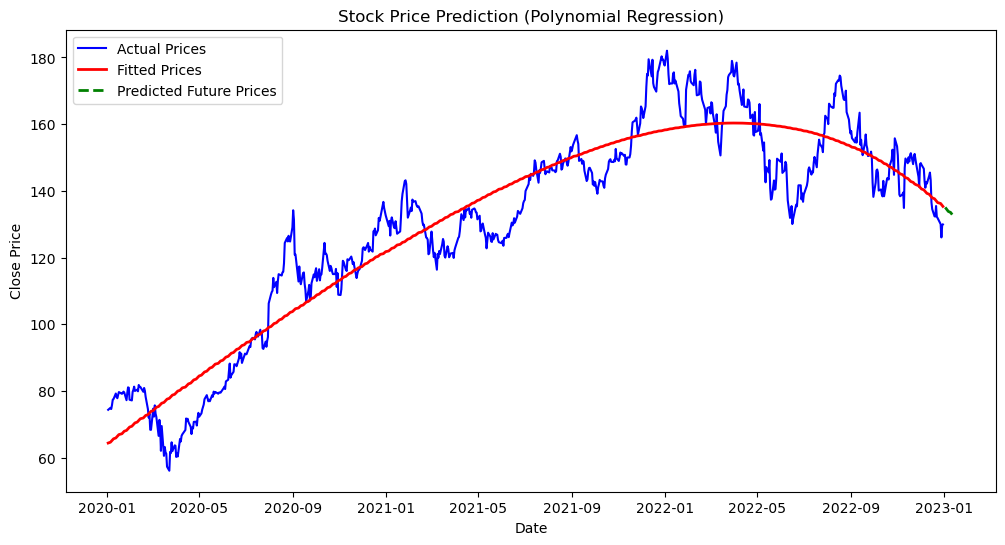

In [18]:
#Predictive Modeling
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Preprocessing Data
stock_data = stock_data.dropna()
stock_data['Days'] = np.arange(len(stock_data))

# Features and target
X = stock_data[['Days']]
Y = stock_data['Close']

# Polynomial regression
degree=4
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, Y)
Y_pred = model.predict(X_poly)

# Predict future stock prices
future_days=10
future_X = pd.DataFrame({'Days': np.arange(len(stock_data) + future_days)})
future_X_poly = poly.transform(future_X)
future_Y_pred = model.predict(future_X_poly)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, Y, color='blue', label='Actual Prices')
plt.plot(stock_data.index, Y_pred, color='red', linewidth=2, label='Fitted Prices')

# Future dates for prediction
future_dates = pd.date_range(start=stock_data.index[-1], periods=future_days + 1, freq='B')[1:]
plt.plot(future_dates, future_Y_pred[-future_days:], color='green', linestyle='--', linewidth=2, label='Predicted Future Prices')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction (Polynomial Regression)')
plt.legend()
plt.show()

In [27]:
#Backtesting Strategy
# Simple Moving Average Strategy
initial_balance = 10000
balance = initial_balance
shares = 0
#stock_data['SMA_20'].dropna()
for i in range(1, len(stock_data)):
    if stock_data['Close'].iloc[i] > stock_data['SMA_20'].iloc[i] and balance > 0:
        shares = balance / stock_data['Close'].iloc[i]
        balance = 0
    elif stock_data['Close'].iloc[i] < stock_data['SMA_20'].iloc[i] and shares > 0:
        balance = shares * stock_data['Close'].iloc[i]
        shares = 0

final_balance = balance + shares * stock_data['Close'].iloc[-1]
cumulative_return = (final_balance - initial_balance) / initial_balance
print(f'Cumulative Return: {cumulative_return * 100:.2f}%')

Cumulative Return: 94.98%


In [26]:
#Visualisation and Reporting
import pandas as pd

# Summary report
summary = pd.DataFrame({
    'Statistic': ['Mean', 'Median', 'Variance', 'Cumulative Return'],
    'Value': [mean_price, median_price, variance_price, cumulative_return * 100]
})
print(summary)

# Export report to CSV
summary.to_csv('stock_summary_report.csv', index=False)

           Statistic       Value
0               Mean  130.311812
1             Median  135.379997
2           Variance  934.310654
3  Cumulative Return   94.981968
